<a href="https://colab.research.google.com/github/123prashanth123/Fault-Detection-System/blob/Colabs/ResNet50%20Extract%20Different%20Depths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import cv2
import matplotlib.pyplot as plt
import torch
import random as r
from torch import nn
from torchvision import models, transforms
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

# Method 1

In [ ]:
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()

        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
        self.size = 224
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = models.resnet50(pretrained=True, progress=True)
        
        self.block1 = nn.Sequential(*[*model.children()][:4])
        self.block2 = nn.Sequential(*[*model.children()][4])
        self.block3 = nn.Sequential(*[*model.children()][5])
        self.block4 = nn.Sequential(*[*model.children()][6])
        self.block5 = nn.Sequential(*[*model.children()][7])

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.block4(x3)
        x5 = self.block5(x4)
        return x1, x2, x3, x4, x5

model = Model_1()
model.eval()
clear_output()


def downscale(image):
    return cv2.resize(src=image, dsize=(model.size, model.size), interpolation=cv2.INTER_AREA)


def upscale(image, w, h):
    return cv2.resize(src=image, dsize=(w, h), interpolation=cv2.INTER_AREA)


def show_feature_images(features, index=0):
    plt.figure(figsize=(8, 6))
    plt.imshow(upscale(features[index].detach().cpu().numpy(), w, h), cmap="gray")
    plt.axis("off")
    plt.show()

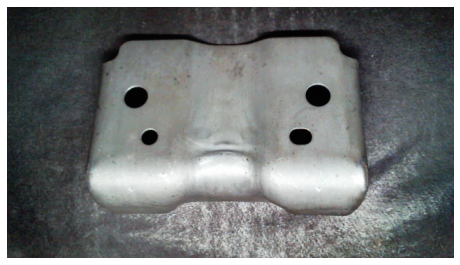

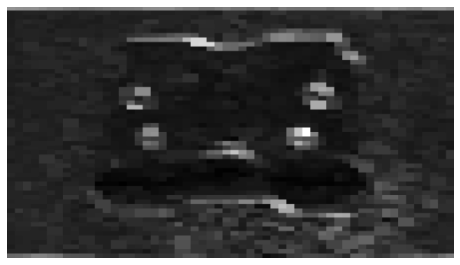

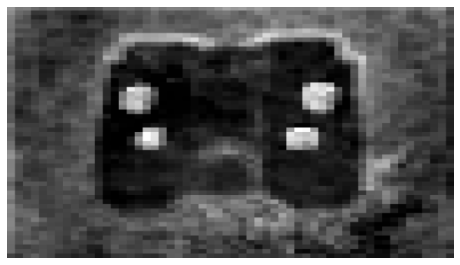

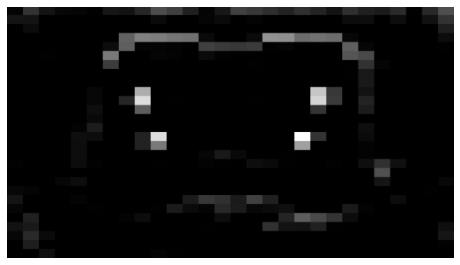

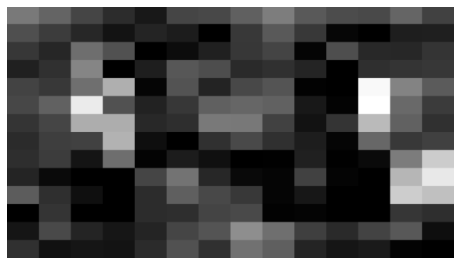

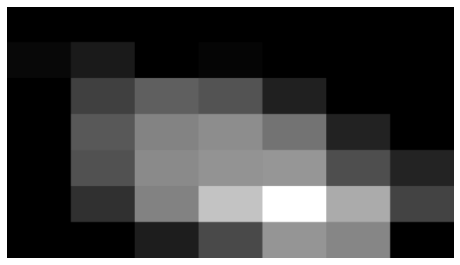

In [ ]:
image = cv2.cvtColor(src=cv2.imread("/content/Snapshot_2.png", cv2.IMREAD_COLOR), code=cv2.COLOR_BGR2RGB)
h, w, _ = image.shape
temp_image = image.copy()
temp_image = downscale(temp_image)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()

with torch.no_grad():
    output_1, output_2, output_3, output_4, output_5 = model(model.transform(temp_image).unsqueeze(dim=0))

# index = r.randint(0, 63)
index = 0
show_feature_images(output_1[0], index=index)
show_feature_images(output_2[0][:64], index=index)
show_feature_images(output_3[0][:64], index=index)
show_feature_images(output_4[0][:64], index=index)
show_feature_images(output_5[0][:64], index=index)

In [ ]:
print(" - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
print(output_1[0].shape)
print(output_2[0].shape)
print(output_3[0].shape)
print(output_4[0].shape)
print(output_5[0].shape)
print(" - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
print(output_1[0].view(-1).shape)
print(output_2[0].view(-1).shape)
print(output_3[0].view(-1).shape)
print(output_4[0].view(-1).shape)
print(output_5[0].view(-1).shape)
print(" - - - - - - - - - - - - - - - - - - - - - - - - - - - ")

 - - - - - - - - - - - - - - - - - - - - - - - - - - - 
torch.Size([64, 56, 56])
torch.Size([256, 56, 56])
torch.Size([512, 28, 28])
torch.Size([1024, 14, 14])
torch.Size([2048, 7, 7])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - 
torch.Size([200704])
torch.Size([802816])
torch.Size([401408])
torch.Size([200704])
torch.Size([100352])
 - - - - - - - - - - - - - - - - - - - - - - - - - - - 


# Method 2

In [ ]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()

        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
        self.size = 224
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = models.resnet50(pretrained=True, progress=True)
        
        self.block1 = nn.Sequential(*[*model.children()][:4])
        self.block2 = nn.Sequential(*[*model.children()][4])
        self.block3 = nn.Sequential(*[*model.children()][5])
        self.block4 = nn.Sequential(*[*model.children()][6])
        self.block5 = nn.Sequential(*[*model.children()][7])

        self.Flatten = nn.Flatten()
        self.AP1 = nn.AdaptiveAvgPool2d(output_size=(8, 4))
        self.AP2 = nn.AdaptiveAvgPool2d(output_size=(4, 2))
        self.AP3 = nn.AdaptiveAvgPool2d(output_size=(2, 2))
        self.AP4 = nn.AdaptiveAvgPool2d(output_size=(2, 1))
        self.AP5 = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    
    def forward(self, x):
        x1 = self.block1(x)
        r1 = self.Flatten(self.AP1(x1))

        x2 = self.block2(x1)
        r2 = self.Flatten(self.AP2(x2))

        x3 = self.block3(x2)
        r3 = self.Flatten(self.AP3(x3))

        x4 = self.block4(x3)
        r4 = self.Flatten(self.AP4(x4))

        x5 = self.block5(x4)
        r5 = self.Flatten(self.AP5(x5))

        return r1, r2, r3, r4, r5

model = Model_2()
model.eval()
clear_output()


def downscale(image):
    return cv2.resize(src=image, dsize=(model.size, model.size), interpolation=cv2.INTER_AREA)


def breaker(num=50, char="*"):
    print("\n" + num*char + "\n")

In [ ]:
image_1 = downscale(cv2.cvtColor(src=cv2.imread("/content/Snapshot_2.png", cv2.IMREAD_COLOR), code=cv2.COLOR_BGR2RGB))
image_2 = downscale(cv2.cvtColor(src=cv2.imread("/content/Snapshot_3.png", cv2.IMREAD_COLOR), code=cv2.COLOR_BGR2RGB))
# image_2 = downscale(cv2.cvtColor(src=cv2.imread("/content/car.jpg", cv2.IMREAD_COLOR), code=cv2.COLOR_BGR2RGB))

with torch.no_grad():
    features_1_1, features_1_2, features_1_3, features_1_4, features_1_5 = model(model.transform(image_1).unsqueeze(dim=0))
    features_2_1, features_2_2, features_2_3, features_2_4, features_2_5 = model(model.transform(image_2).unsqueeze(dim=0))


breaker()
print("First Layer Features  : {:.5f}".format(nn.CosineSimilarity()(features_1_1, features_2_1).item()))
breaker()
print("Second Layer Features : {:.5f}".format(nn.CosineSimilarity()(features_1_2, features_2_2).item()))
breaker()
print("Thrid Layer Features  : {:.5f}".format(nn.CosineSimilarity()(features_1_3, features_2_3).item()))
breaker()
print("Fourth Layer Features : {:.5f}".format(nn.CosineSimilarity()(features_1_4, features_2_4).item()))
breaker()
print("Fifth Layer Features  : {:.5f}".format(nn.CosineSimilarity()(features_1_5, features_2_5).item()))
breaker()

avg_features_1 = torch.mean(features_1_1 + features_1_2 + features_1_3 + features_1_4 + features_1_5, dim=0).view(1, -1)
avg_features_2 = torch.mean(features_2_1 + features_2_2 + features_2_3 + features_2_4 + features_2_5, dim=0).view(1, -1)

print("Average Features     : {:.5f}".format(nn.CosineSimilarity()(avg_features_1, avg_features_2).item()))
breaker()


**************************************************

First Layer Features  : 0.97987

**************************************************

Second Layer Features : 0.99219

**************************************************

Thrid Layer Features  : 0.98479

**************************************************

Fourth Layer Features : 0.93899

**************************************************

Fifth Layer Features  : 0.89451

**************************************************

Average Features     : 0.96999

**************************************************

